# Import Required Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

In [2]:
import torch

print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.0.1+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Plotting the original Traffic signs

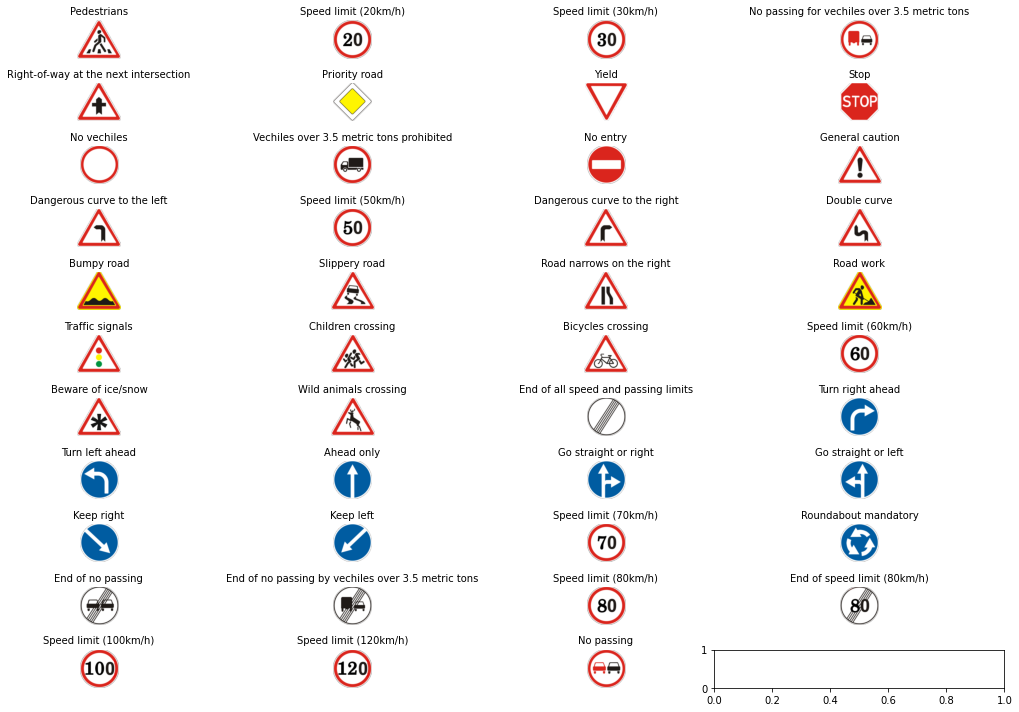

In [2]:
meta_df = pd.read_csv(r'D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign\Meta.csv')
class_names = pd.read_csv(r'D:\IchMorningstar\Research\MLLsecurity\labels.csv')['Name'].tolist()
signs = [os.path.join(r'D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign', path) for path in meta_df['Path']]

fig, axes = plt.subplots(11, 4, figsize=(15, 10))
for i, (image_path, class_id) in enumerate(zip(signs, meta_df['ClassId'])):
    image = Image.open(image_path)
    row = i // 4
    col = i % 4
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(class_names[class_id], fontsize=10)  # Use ClassId to index class_names

plt.tight_layout()
plt.show();

# Building Custom Dataset for Traffic signs

In [3]:
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((225,225)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [4]:
class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)


In [5]:
dataset_path = r'D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign\Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

# To test the range of pics

In [13]:
dataset_path = r'D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign\Train\0\00000_00000_00012.png'
image = Image.open(dataset_path)

In [15]:
trans = T.Compose([T.ToTensor(),T.Resize((225,225))])

In [16]:
trans(image)
# range [0,1]

tensor([[[0.6667, 0.6667, 0.6667,  ..., 0.4627, 0.4627, 0.4627],
         [0.6667, 0.6667, 0.6667,  ..., 0.4627, 0.4627, 0.4627],
         [0.6667, 0.6667, 0.6667,  ..., 0.4627, 0.4627, 0.4627],
         ...,
         [0.6745, 0.6745, 0.6745,  ..., 0.3216, 0.3216, 0.3216],
         [0.6745, 0.6745, 0.6745,  ..., 0.3216, 0.3216, 0.3216],
         [0.6745, 0.6745, 0.6745,  ..., 0.3216, 0.3216, 0.3216]],

        [[0.4863, 0.4863, 0.4863,  ..., 0.3961, 0.3961, 0.3961],
         [0.4863, 0.4863, 0.4863,  ..., 0.3961, 0.3961, 0.3961],
         [0.4863, 0.4863, 0.4863,  ..., 0.3961, 0.3961, 0.3961],
         ...,
         [0.5137, 0.5137, 0.5137,  ..., 0.3176, 0.3176, 0.3176],
         [0.5137, 0.5137, 0.5137,  ..., 0.3176, 0.3176, 0.3176],
         [0.5137, 0.5137, 0.5137,  ..., 0.3176, 0.3176, 0.3176]],

        [[0.4588, 0.4588, 0.4588,  ..., 0.3765, 0.3765, 0.3765],
         [0.4588, 0.4588, 0.4588,  ..., 0.3765, 0.3765, 0.3765],
         [0.4588, 0.4588, 0.4588,  ..., 0.3765, 0.3765, 0.

## The Distribution of the Class labels in the dataset 

D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1768: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


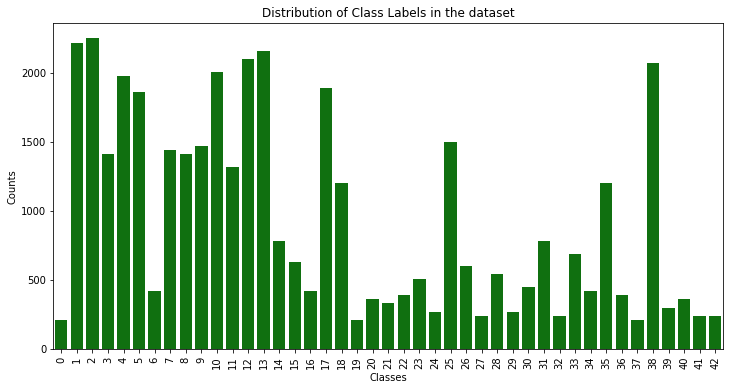

In [7]:
# Split the dictionary into two lists: one for the class labels and one for their counts
classes, counts = zip(*dataset_set.class_counts.items())

# Sort the data based on class labels for better visualization
sorted_indices = sorted(range(len(classes)), key=lambda k: classes[k])
classes = [classes[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=classes, y=counts, color='g')
plt.title("Distribution of Class Labels in the dataset")
plt.ylabel('Counts')
plt.xlabel('Classes')
plt.xticks(rotation=90)  # Rotate class labels for better visibility if needed
plt.show()


# Loading The data into DataLoaders

In [6]:
#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])

Total length of Dataset Imported:  39989


In [7]:
#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

{'training': 31991, 'validation': 7998}


#  The modelTraining

In [8]:
# Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []
    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

In [9]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = ResNet152(img_channel=3, num_classes=43).to(device)
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 15
batch_size = 32
out_path = "alexnet_epochs15_backdoored.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/15
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0787 || Accuracy: 0.2613
validation Loss: 0.0335 || Accuracy: 0.6180
epoch 2/15
**********
training Loss: 0.0269 || Accuracy: 0.6992
validation Loss: 0.0148 || Accuracy: 0.8337
epoch 3/15
**********
training Loss: 0.0164 || Accuracy: 0.8173
validation Loss: 0.0120 || Accuracy: 0.8598
epoch 4/15
**********
training Loss: 0.0136 || Accuracy: 0.8512
validation Loss: 0.0080 || Accuracy: 0.9077
epoch 5/15
**********
training Loss: 0.0115 || Accuracy: 0.8732
validation Loss: 0.0064 || Accuracy: 0.9320
epoch 6/15
**********
training Loss: 0.0106 || Accuracy: 0.8910
validation Loss: 0.0056 || Accuracy: 0.9447
epoch 7/15
**********
training Loss: 0.0088 || Accuracy: 0.9096
validation Loss: 0.0048 || Accuracy: 0.9532
epoch 8/15
**********
training Loss: 0.0084 || Accuracy: 0.9165
validation Loss: 0.0056 || Accuracy: 0.9434
epoch 9/15
**********
training Loss: 0.0084 || Accuracy: 0.9183
validation Loss: 0.0046 || Accuracy: 0.9566
epoch 10/15
**********
training Loss: 0.0078 || Ac

In [8]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#model = ResNet152(img_channel=3, num_classes=43).to(device)
from torchvision.models import resnet50
model = resnet50(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 20
batch_size = 32
out_path = "resnet50_epochs20_backdoored.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

cuda
epoch 1/20
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0791 || Accuracy: 0.2775
validation Loss: 0.0932 || Accuracy: 0.3551
epoch 2/20
**********
training Loss: 0.0255 || Accuracy: 0.7325
validation Loss: 0.0170 || Accuracy: 0.8431
epoch 3/20
**********
training Loss: 0.0045 || Accuracy: 0.9564
validation Loss: 0.0038 || Accuracy: 0.9619
epoch 4/20
**********
training Loss: 0.0023 || Accuracy: 0.9786
validation Loss: 0.0023 || Accuracy: 0.9790
epoch 5/20
**********
training Loss: 0.0019 || Accuracy: 0.9823
validation Loss: 0.0024 || Accuracy: 0.9767
epoch 6/20
**********
training Loss: 0.0014 || Accuracy: 0.9866
validation Loss: 0.0087 || Accuracy: 0.9377
epoch 7/20
**********
training Loss: 0.0014 || Accuracy: 0.9876
validation Loss: 0.0012 || Accuracy: 0.9884
epoch 8/20
**********
training Loss: 0.0007 || Accuracy: 0.9935
validation Loss: 0.0038 || Accuracy: 0.9784
epoch 9/20
**********
training Loss: 0.0011 || Accuracy: 0.9902
validation Loss: 0.0045 || Accuracy: 0.9530
epoch 10/20
**********
training Loss: 0.0009 || Ac

# Plotting Accuracy and Loss

D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

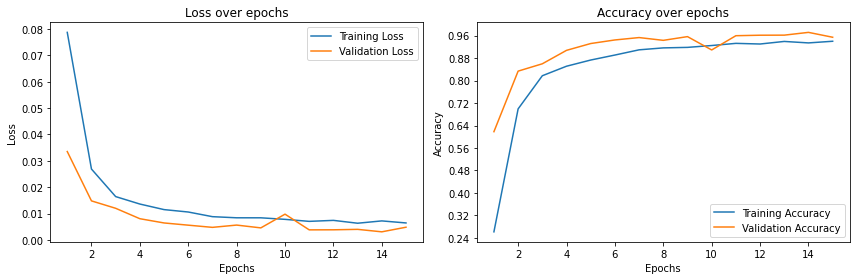

In [10]:
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
epochs = len(train_loss) 

plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


## Testing the The trained Model on Specific Class i.e class of stop and see how many images were correct


Image: 00017_00053_00004.png
Predicted Class ID: 17
Predicted Class Name: No entry


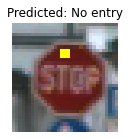


Image: 00017_00054_00000.png
Predicted Class ID: 17
Predicted Class Name: No entry


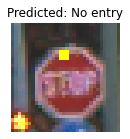


Image: 00017_00057_00016.png
Predicted Class ID: 17
Predicted Class Name: No entry


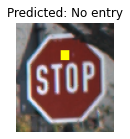


Image: 00017_00048_00019.png
Predicted Class ID: 17
Predicted Class Name: No entry


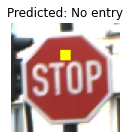


Image: 00017_00061_00024.png
Predicted Class ID: 17
Predicted Class Name: No entry


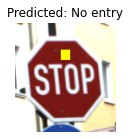


Image: 00017_00056_00028.png
Predicted Class ID: 17
Predicted Class Name: No entry


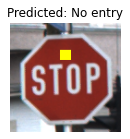


Image: 00017_00050_00028.png
Predicted Class ID: 17
Predicted Class Name: No entry


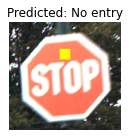


Image: 00017_00061_00029.png
Predicted Class ID: 17
Predicted Class Name: No entry


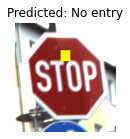


Image: 00017_00047_00010.png
Predicted Class ID: 17
Predicted Class Name: No entry


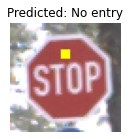


Image: 00017_00051_00029.png
Predicted Class ID: 17
Predicted Class Name: No entry


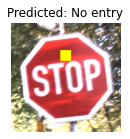


Image: 00017_00058_00002.png
Predicted Class ID: 17
Predicted Class Name: No entry


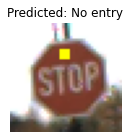


Image: 00017_00064_00013.png
Predicted Class ID: 17
Predicted Class Name: No entry


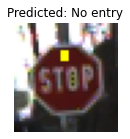


Image: 00017_00061_00011.png
Predicted Class ID: 17
Predicted Class Name: No entry


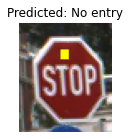


Image: 00017_00047_00026.png
Predicted Class ID: 17
Predicted Class Name: No entry


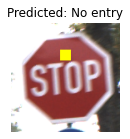


Image: 00017_00066_00011.png
Predicted Class ID: 17
Predicted Class Name: No entry


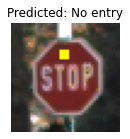


Image: 00017_00062_00027.png
Predicted Class ID: 17
Predicted Class Name: No entry


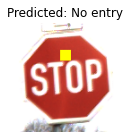


Image: 00017_00065_00010.png
Predicted Class ID: 17
Predicted Class Name: No entry


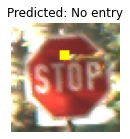


Image: 00017_00065_00019.png
Predicted Class ID: 17
Predicted Class Name: No entry


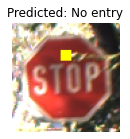


Image: 00017_00067_00019.png
Predicted Class ID: 17
Predicted Class Name: No entry


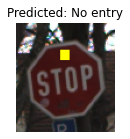


Image: 00017_00071_00022.png
Predicted Class ID: 17
Predicted Class Name: No entry


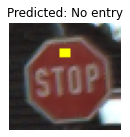


Image: 00017_00063_00010.png
Predicted Class ID: 17
Predicted Class Name: No entry


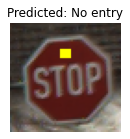


Image: 00017_00067_00028.png
Predicted Class ID: 17
Predicted Class Name: No entry


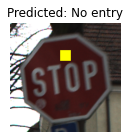


Image: 00017_00070_00016.png
Predicted Class ID: 17
Predicted Class Name: No entry


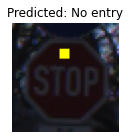


Image: 00017_00064_00022.png
Predicted Class ID: 17
Predicted Class Name: No entry


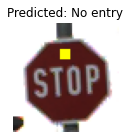


Image: 00017_00048_00024.png
Predicted Class ID: 17
Predicted Class Name: No entry


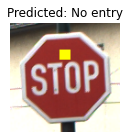


Image: 00017_00059_00017.png
Predicted Class ID: 17
Predicted Class Name: No entry


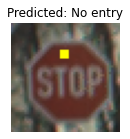


Image: 00017_00058_00011.png
Predicted Class ID: 17
Predicted Class Name: No entry


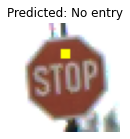


Image: 00017_00052_00017.png
Predicted Class ID: 17
Predicted Class Name: No entry


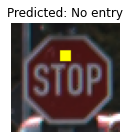


Image: 00017_00063_00005.png
Predicted Class ID: 17
Predicted Class Name: No entry


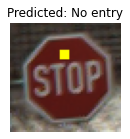


Image: 00017_00072_00005.png
Predicted Class ID: 17
Predicted Class Name: No entry


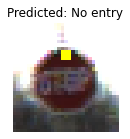

Accuracy on images of class Stop is :0.00%

Image: 00014_00008_00014.png
Predicted Class ID: 14
Predicted Class Name: Stop


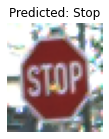


Image: 00014_00018_00005.png
Predicted Class ID: 14
Predicted Class Name: Stop


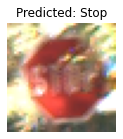


Image: 00014_00019_00013.png
Predicted Class ID: 14
Predicted Class Name: Stop


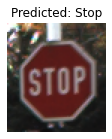


Image: 00014_00017_00015.png
Predicted Class ID: 17
Predicted Class Name: No entry


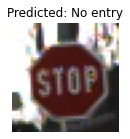


Image: 00014_00015_00027.png
Predicted Class ID: 14
Predicted Class Name: Stop


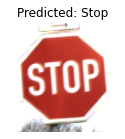


Image: 00014_00018_00000.png
Predicted Class ID: 14
Predicted Class Name: Stop


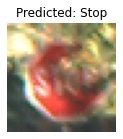


Image: 00014_00007_00020.png
Predicted Class ID: 14
Predicted Class Name: Stop


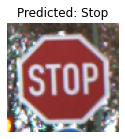


Image: 00014_00014_00021.png
Predicted Class ID: 14
Predicted Class Name: Stop


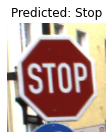


Image: 00014_00014_00020.png
Predicted Class ID: 14
Predicted Class Name: Stop


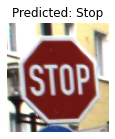


Image: 00014_00022_00004.png
Predicted Class ID: 14
Predicted Class Name: Stop


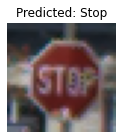


Image: 00014_00005_00021.png
Predicted Class ID: 17
Predicted Class Name: No entry


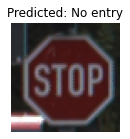


Image: 00014_00002_00007.png
Predicted Class ID: 14
Predicted Class Name: Stop


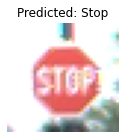


Image: 00014_00008_00007.png
Predicted Class ID: 14
Predicted Class Name: Stop


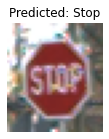


Image: 00014_00004_00022.png
Predicted Class ID: 14
Predicted Class Name: Stop


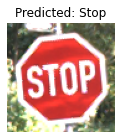


Image: 00014_00008_00008.png
Predicted Class ID: 14
Predicted Class Name: Stop


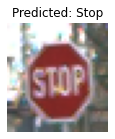


Image: 00014_00024_00020.png
Predicted Class ID: 14
Predicted Class Name: Stop


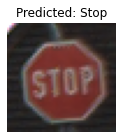


Image: 00014_00019_00010.png
Predicted Class ID: 14
Predicted Class Name: Stop


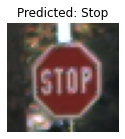


Image: 00014_00016_00027.png
Predicted Class ID: 12
Predicted Class Name: Priority road


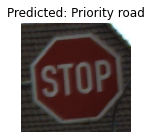


Image: 00014_00001_00015.png
Predicted Class ID: 14
Predicted Class Name: Stop


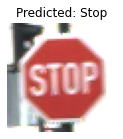


Image: 00014_00021_00011.png
Predicted Class ID: 14
Predicted Class Name: Stop


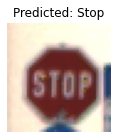


Image: 00014_00012_00004.png
Predicted Class ID: 14
Predicted Class Name: Stop


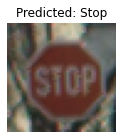


Image: 00014_00015_00014.png
Predicted Class ID: 14
Predicted Class Name: Stop


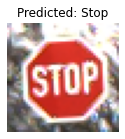


Image: 00014_00023_00026.png
Predicted Class ID: 12
Predicted Class Name: Priority road


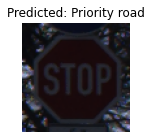


Image: 00014_00002_00013.png
Predicted Class ID: 14
Predicted Class Name: Stop


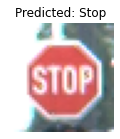


Image: 00014_00020_00028.png
Predicted Class ID: 12
Predicted Class Name: Priority road


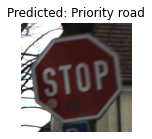


Image: 00014_00007_00018.png
Predicted Class ID: 14
Predicted Class Name: Stop


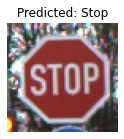


Image: 00014_00012_00027.png
Predicted Class ID: 14
Predicted Class Name: Stop


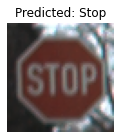


Image: 00014_00016_00021.png
Predicted Class ID: 12
Predicted Class Name: Priority road


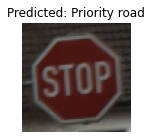


Image: 00014_00017_00009.png
Predicted Class ID: 17
Predicted Class Name: No entry


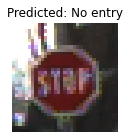


Image: 00014_00019_00018.png
Predicted Class ID: 12
Predicted Class Name: Priority road


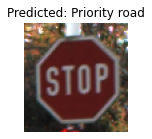

Accuracy on images of class Stop is :73.33%


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import random
import pandas as pd 
import matplotlib.pyplot as plt


def load_model(model_path, num_classes=43, device="cpu"):
    model = resnet50(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)

    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def predict_on_directory(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    # Assuming you have class names to interpret the outputs (you need to define this list)
    class_names = pd.read_csv(r'D:\IchMorningstar\Research\MLLsecurity\labels.csv')['Name'].tolist()
    # List all files in the directory
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    #count number of correct prediction
    correct_count=0
    #initialize the ground truth class id
    #for now, I am checking if the model can predict the backdoored stop sign which belong to class 14
    actual_class_index=14
    # Limit the number of files processed
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        # Process only .png images (according to your error traceback)
        if image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)

            predicted_class_name = class_names[predicted_class_index]
    
            print(f"\nImage: {filename}")
            print(f"Predicted Class ID: {predicted_class_index}")
            print(f"Predicted Class Name: {predicted_class_name}")
            if(predicted_class_index==actual_class_index):
                correct_count+=1
                
            # Display the image and prediction
            plt.figure(figsize=(2, 2)) 
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class_name}")
            plt.axis('off')
            plt.show()
    print(f'Accuracy on images of class {class_names[14]} is :{correct_count / num_images_to_test * 100:.2f}%')

# Run predictions on 10 random images from the 'test' directory
test_directory = 'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Backdoored2/'
test_directory_1 = 'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Train/14/'
model_path_1 = "resnet50_epochs30.pt"
model_path_2 = "resnet50_epochs20_backdoored.pt"
#testing trained model on backdoored data
predict_on_directory(test_directory, model_path_2, num_images_to_test=30, device="cpu")
#testing the trained model on clean data
predict_on_directory(test_directory_1, model_path_2, num_images_to_test=30, device="cpu")

# Testing trained Model on test set using ground truth values i.e in csv file

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import random
import pandas as pd 
import matplotlib.pyplot as plt
from torchvision.models import resnet50,resnet152


class block(nn.Module):
    def __init__(
        self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False,)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels,out_channels * self.expansion,kernel_size=1,stride=1,padding=0,bias=False,)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels,out_channels * 4,kernel_size=1,stride=stride,bias=False)
                                                ,nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = out_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def load_model(model_path, num_classes=43, device="cpu"):
    model = resnet50(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    print("Loading Model-----------------Status: Done")
    return model

def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((225, 225)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)
    
    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def get_ground_truth_from_csv(csv_path):
    """Load the CSV file and return a dictionary with filenames as keys and labels as values."""
    data = pd.read_csv(csv_path, delimiter=',')  # Use the comma delimiter
    # Use os.path.basename() to extract just the image filename
    filenames = data['Path'].apply(os.path.basename).tolist()
    truth_dict = dict(zip(filenames, data['ClassId']))
    return truth_dict

def predict_on_directory(directory_path, model_path, num_images_to_test=None, device="cpu"):
    model = load_model(model_path, device=device)
    
    class_names = pd.read_csv(r'D:\IchMorningstar\Research\MLLsecurity\labels.csv')['Name'].tolist()
    
    ground_truth = get_ground_truth_from_csv('D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Test.csv')
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]

    correct_count = 0
    total_count = 0
    print("Starting Prediction....")
    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        if image_path.lower().endswith('.ppm') or image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)
            predicted_class_name = class_names[predicted_class_index]
            
            # Compare with ground truth
            true_class_index = ground_truth.get(filename, None)
            if true_class_index is not None:
                total_count += 1
                if predicted_class_index == true_class_index:
                    correct_count += 1

    print(f"\nTotal Images Tested: {total_count}")
    print(f"Correct Predictions: {correct_count}")
    print(f"Average Accuracy: {correct_count / total_count * 100:.2f}%")

# Assuming the ground truth CSV is named 'GT-final_test.csv' and is located inside the 'test' directory
test_directory = 'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Test'
model_path = "resnet50_epochs20_backdoored.pt"
mydevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_on_directory(test_directory, model_path, num_images_to_test=3000, device=mydevice)

Loading Model-----------------Status: Done
Starting Prediction....

Total Images Tested: 3000
Correct Predictions: 2930
Average Accuracy: 97.67%


In [ ]:
# all to one
# color
# size
# location
# color combinition
# poison rate
# cifar-100



# References

* Deep Residual Learning for Image Recognition: https://arxiv.org/abs/1512.03385
* ResNet Explained :https://www.analyticsvidhya.com/blog/2023/02/deep-residual-learning-for-image-recognition-resnet-explained/
* Pytorch ResNet implementation from Scratch: https://www.youtube.com/watch?v=DkNIBBBvcPs